# In this notebook

## Aims
Create a model to estimate solubility using different linear regression methods.

* L2 regularisation (Ridge Regression)
* L1 regularisation (Lasso Regression)
* Partial Least Squares (PLS Regression)

And some ensemble methods

* Random Forest Regressor
* Gradient Boosting Regression

Analysis of outliers through clustering.

Data was provided by AI4SD as part of the 2022 Summer School Hackathon.

## Results (on test set)

L2 regularisation
* R-squared: 0.910
* RMSE: 0.648

L1 regularisation
* R-squared: 0.908
* RMSE: 0.655

PLS
* R-squared: 0.90
* RMSE: 0.672

Random Forest
* R-squared: 0.918
* RMSE: 0.617

Gradient Boosted Regression
* R-squared: 0.924
* RMSE: 0.595

Clustering
* Largest cluster of outliers seems to be mostly aromatic compounds

## Potential Improvements
* Cross validation

## Preparation and EDA

In [91]:
# For data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For chemistry
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
import mols2grid

# For regression analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

In [2]:
# Import the data
raw_df = pd.read_excel("solubility_data.xlsx", engine='openpyxl', verbose=False)

In [3]:
raw_df.shape

(932, 2261)

932 data points with 2261 features.

In [4]:
raw_df.head()

,0,Compound_Identifier,Source,SMILES,LogS.M.,MW,AMW,Sv,Se,Sp,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50_x000D__x000D_\n
0,1,HU_100,Huuskonen,c1ccc2ccc3nccnc3c2c1,-2.68,180.22,8.192,15.623,21.854,16.296,...,0,0,0,0,1,0,1,0,1,0_x000D__x000D_\n
1,2,HU_1000,Huuskonen,c1cnc2c(C)ncnc2n1,-0.12,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0_x000D__x000D_\n
2,3,HU_1001,Huuskonen,c1cnc2cnc(C)nc2n1,-0.47,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0_x000D__x000D_\n
3,4,HU_1002,Huuskonen,c1c(C)nc2cncnc2n1,0.06,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0_x000D__x000D_\n
4,5,HU_1003,Huuskonen,c1cnc2c(OC)ncnc2n1,-1.11,162.17,9.009,12.327,18.618,12.239,...,0,0,0,0,0,0,0,0,0,0_x000D__x000D_\n


In [5]:
print(f"Duplicates: {raw_df.duplicated().sum()}, missing values: {raw_df.isna().all().sum()}")

Duplicates: 0, missing values: 0


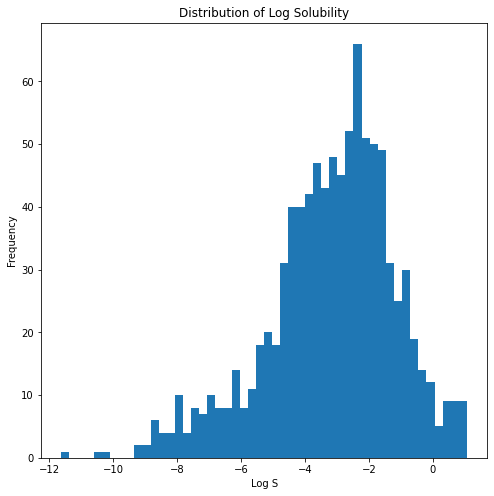

In [6]:
plt.figure(figsize=(8,8))
plt.hist(raw_df['LogS.M.'], bins=50)
plt.xlabel('Log S')
plt.ylabel('Frequency')
plt.title('Distribution of Log Solubility')
plt.show()

In [7]:
y = raw_df["LogS.M."].values # Target values
X = raw_df[raw_df.columns[5:-1]] # Features
col_labels = raw_df.columns[5:-1]
X = X.to_numpy()
N, p = X.shape
print(X.shape)
print(y.shape)

(932, 2255)
(932,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
# Remove sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Using L2 Regularisation

L2 regularisation adds a penalty which is equal to the square of the magnitude of coefficients to reduce overfitting. In this notebook I am using Ridge regression. Ridge regression can deal well with multicolinearity, but is prone to overfitting when the number of features is larger than the number of data points.

In [10]:
from sklearn.linear_model import Ridge

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 31.82it/s]


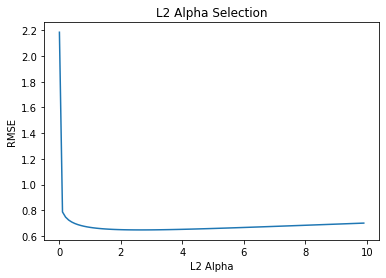

Best L2 alpha: 2.6


In [11]:
rmse = []
array = np.arange(0,10,0.1)
for alpha in tqdm(array):
    clf_alpha = Ridge(alpha=alpha, normalize=True)
    clf_alpha.fit(X_train, y_train)
    rmse.append(mean_squared_error(y_test, clf_alpha.predict(X_test), squared=False))
    
plt.plot(array, rmse)
plt.xlabel('L2 Alpha')
plt.ylabel('RMSE')
plt.title('L2 Alpha Selection')
plt.show()

best_alpha = array[min(range(len(rmse)), key=rmse.__getitem__)]

print(f"Best L2 alpha: {best_alpha}")

In [12]:
clf = Ridge(alpha=best_alpha, normalize=True)
clf.fit(X_train, y_train)

Ridge(alpha=2.6, normalize=True)

In [13]:
l2_r_squared_train = clf.score(X_train, y_train)
l2_r_squared_test = clf.score(X_test, y_test)
l2_train_rmse = mean_squared_error(y_train, clf.predict(X_train), squared=False)
l2_test_rmse = mean_squared_error(y_test, clf.predict(X_test), squared=False)

Training set R-squared (using L2 regularisation): 0.9238346484460714
Training set RMSE (using L2 regularisation): 0.5392262255940069


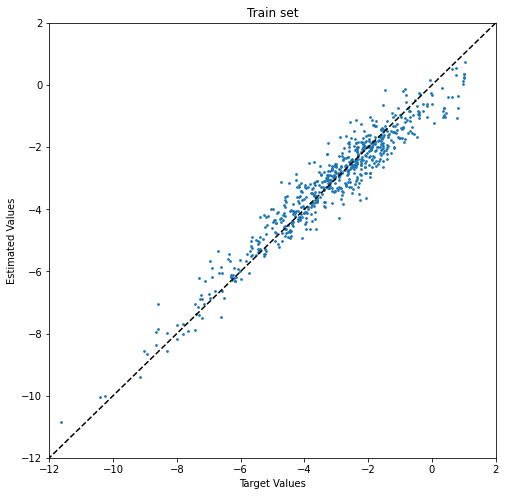

In [14]:
print(f"Training set R-squared (using L2 regularisation): {l2_r_squared_train}")
print(f"Training set RMSE (using L2 regularisation): {l2_train_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_train, clf.predict(X_train), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Train set");

Test set R-squared (using L2 regularisation): 0.9098616575434052
Test set RMSE (using L2 regularisation): 0.6482560362927892


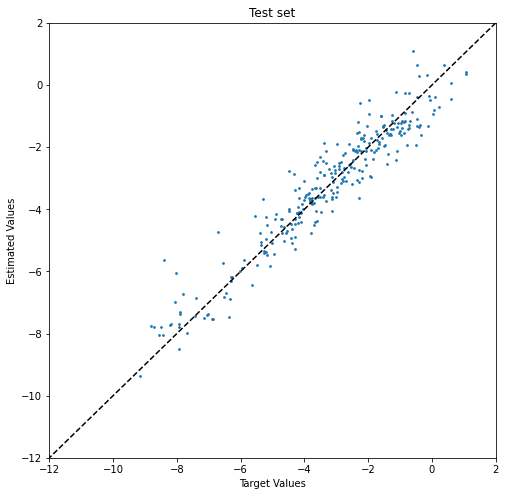

In [15]:
print(f"Test set R-squared (using L2 regularisation): {l2_r_squared_test}")
print(f"Test set RMSE (using L2 regularisation): {l2_test_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_test, clf.predict(X_test), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Test set");

In [64]:
coefs_list = []
coefs = {}
for index, coef in enumerate(clf.coef_):
    coefs[col_labels[index]] = coef
    coefs_list.append((col_labels[index], abs(coef)))
    
coefs_list_sorted = sorted(coefs_list, key=lambda x: x[1], reverse=True)[:10]
coefs_list_sorted

print("Top 10 features:")
for tup in coefs_list_sorted:
    print(f"Feature: {tup[0]}, coefficient: {coefs.get(tup[0])}")

Top 10 features:
Feature: X5Av, coefficient: -1.2211828187935847
Feature: JGI10, coefficient: -1.0687760194765694
Feature: ChiA_X, coefficient: 0.6925721315153593
Feature: Psi_i_t, coefficient: -0.6749634622927474
Feature: X4Av, coefficient: -0.60751144690975
Feature: JGI5, coefficient: -0.5738603262967563
Feature: X3Av, coefficient: -0.5201616911699961
Feature: LLS_02, coefficient: 0.4824645702687945
Feature: ChiA_B(s), coefficient: -0.46748214314043324
Feature: JGI7, coefficient: -0.46104930243021836


The R-squared and MSE values are better for the training set than the test set, showing there is some overfitting.

## Using L1 Regularisation

L1 regularisation adds a penalty which is equal to the absolute value of the magnitude of coefficients to prevent overfitting. In this notebook I am using Lasso Regression. Lasso regression is useful when dealing with a high number of features as it returns a sparse solution.

In [16]:
from sklearn.linear_model import Lasso

100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.69it/s]


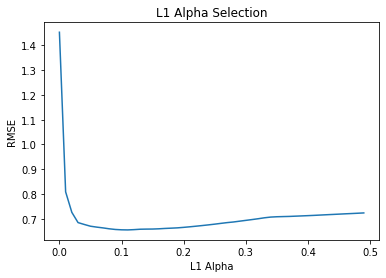

Best L1 alpha: 0.11


In [17]:
rmse = []
array = np.arange(0,0.5,0.01)

for alpha in tqdm(array):
    clf_l1_alpha = Lasso(alpha=alpha, normalize=False)
    clf_l1_alpha.fit(X_train, y_train)
    rmse.append(mean_squared_error(y_test, clf_l1_alpha.predict(X_test), squared=False))
    
plt.plot(array, rmse)
plt.xlabel('L1 Alpha')
plt.ylabel('RMSE')
plt.title('L1 Alpha Selection')
plt.show()

best_alpha = array[min(range(len(rmse)), key=rmse.__getitem__)]

print(f"Best L1 alpha: {best_alpha}")

In [18]:
clf_l1 = Lasso(alpha=best_alpha)
clf_l1.fit(X_train, y_train)

Lasso(alpha=0.11)

In [19]:
l1_r_squared_train = clf_l1.score(X_train, y_train)
l1_r_squared_test = clf_l1.score(X_test, y_test)
l1_train_rmse = mean_squared_error(y_train, clf_l1.predict(X_train), squared=False)
l1_test_rmse = mean_squared_error(y_test, clf_l1.predict(X_test), squared=False)

Training set R-squared (using L1 regularisation): 0.9008126271371361
Training set RMSE (using L1 regularisation): 0.6153475480718384


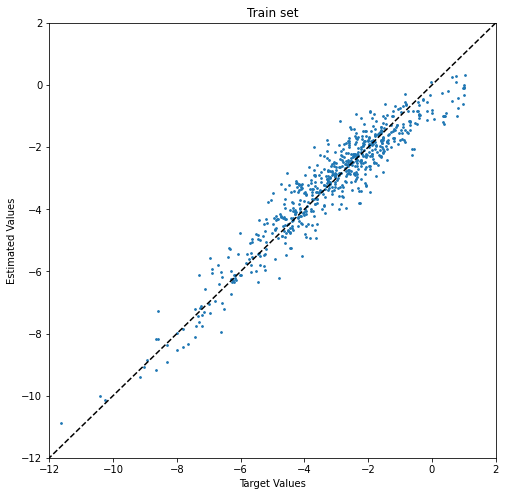

In [20]:
print(f"Training set R-squared (using L1 regularisation): {l1_r_squared_train}")
print(f"Training set RMSE (using L1 regularisation): {l1_train_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_train, clf_l1.predict(X_train), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Train set");

Test set R-squared (using L1 regularisation): 0.90800624500637
Test set RMSE (using L1 regularisation): 0.6548939203764955


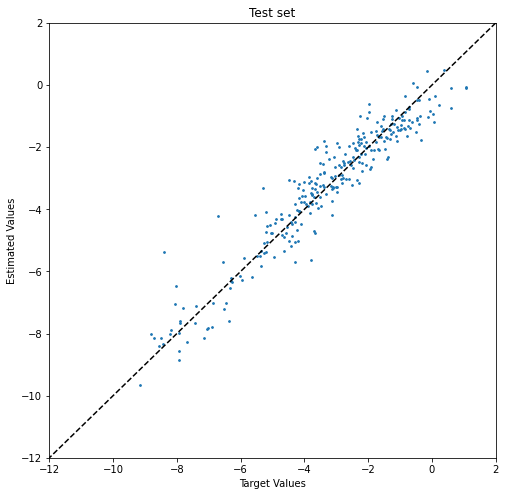

In [21]:
print(f"Test set R-squared (using L1 regularisation): {l1_r_squared_test}")
print(f"Test set RMSE (using L1 regularisation): {l1_test_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_test, clf_l1.predict(X_test), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Test set");

In [65]:
coefs_list = []
coefs = {}
for index, coef in enumerate(clf_l1.coef_):
    coefs[col_labels[index]] = coef
    coefs_list.append((col_labels[index], abs(coef)))
    
coefs_list_sorted = sorted(coefs_list, key=lambda x: x[1], reverse=True)[:10]
coefs_list_sorted

print("Top 10 features:")
for tup in coefs_list_sorted:
    print(f"Feature: {tup[0]}, coefficient: {coefs.get(tup[0])}")

Top 10 features:
Feature: MLOGP2, coefficient: -0.0828176610795127
Feature: H-046, coefficient: -0.06980207518777409
Feature: CATS2D_01_LL, coefficient: -0.05955679589423563
Feature: F02[C-N], coefficient: 0.020288179771743887
Feature: RDSQ, coefficient: 0.013796571636865835
Feature: TIC0, coefficient: 0.013572181704088
Feature: Chi0_EA(dm), coefficient: 0.008752770339999074
Feature: Eig10_EA(ed), coefficient: 0.00824905815384897
Feature: AMR, coefficient: -0.008173279024006304
Feature: Vx, coefficient: -0.008123084994957095


The performances of the L1 and L2 models are almost identical. 

## Using PLS Regression

PLS is good for when there is a large number of features, and multicollinearity among them. 

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 29.81it/s]


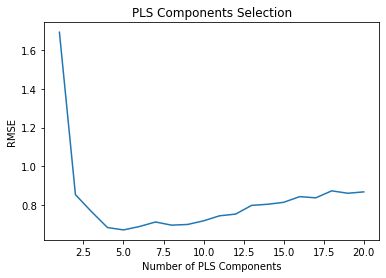

Best Number of PLS Components: 5


In [22]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale

rmse = []
for i in tqdm(np.arange(1, 21)):
    pls = PLSRegression(n_components=i, scale=True)
    pls.fit(X_train, y_train)
    rmse.append(mean_squared_error(y_test, pls.predict(X_test), squared=False))
    
plt.plot(np.arange(1,21), rmse)
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('PLS Components Selection')
plt.show()

best_components = np.arange(1,21)[min(range(len(rmse)), key=rmse.__getitem__)]

print(f"Best Number of PLS Components: {best_components}")

In [23]:
pls = PLSRegression(n_components=best_components, scale=True)
pls.fit(X_train, y_train)

PLSRegression(n_components=5)

In [24]:
pls_r_squared_train = pls.score(X_train, y_train)
pls_r_squared_test = pls.score(X_test, y_test)
pls_train_rmse = mean_squared_error(y_train, pls.predict(X_train), squared=False)
pls_test_rmse = mean_squared_error(y_test, pls.predict(X_test), squared=False)

Training set R-squared (using PLS): 0.900520483484702
Training set RMSE (using PLS): 0.6162530953070521


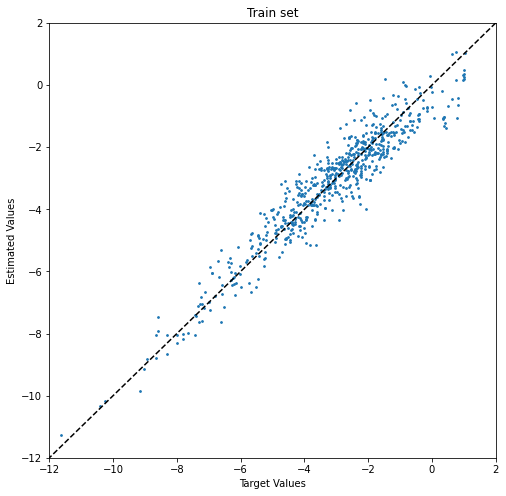

In [25]:
print(f"Training set R-squared (using PLS): {pls_r_squared_train}")
print(f"Training set RMSE (using PLS): {pls_train_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_train, pls.predict(X_train), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Train set");

Test set R-squared (using PLS): 0.9032501845840871
Test set RMSE (using PLS): 0.6716095425654866


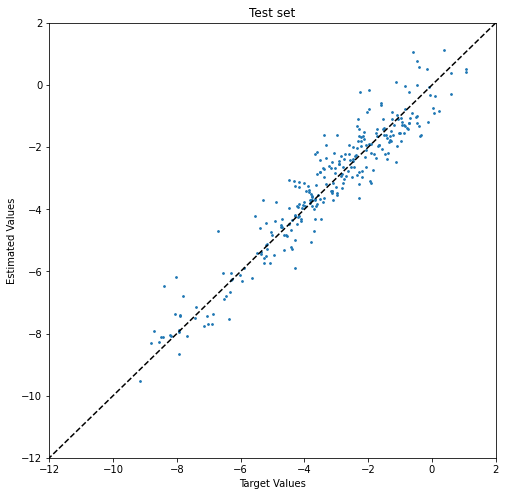

In [26]:
print(f"Test set R-squared (using PLS): {pls_r_squared_test}")
print(f"Test set RMSE (using PLS): {pls_test_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_test, pls.predict(X_test), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Test set");

In [79]:
coefs_list = []
coefs = {}
for index, coef in enumerate(pls.coef_):
    coefs[col_labels[index]] = coef[0]
    coefs_list.append((col_labels[index], abs(coef)))
    
coefs_list_sorted = sorted(coefs_list, key=lambda x: x[1], reverse=True)[:10]
coefs_list_sorted

print("Top 10 features:")
for tup in coefs_list_sorted:
    print(f"Feature: {tup[0]}, coefficient: {coefs.get(tup[0])}")

Top 10 features:
Feature: LLS_02, coefficient: 0.039206757727905
Feature: MLOGP2, coefficient: -0.03497042980289603
Feature: ALOGP2, coefficient: -0.03035286018097782
Feature: ALOGP, coefficient: -0.029916855480084922
Feature: MLOGP, coefficient: -0.02939732778781587
Feature: BLTD48, coefficient: 0.029395117211529244
Feature: BLTF96, coefficient: 0.029394472765089066
Feature: BLTA96, coefficient: 0.02939251026136168
Feature: DLS_01, coefficient: 0.028513420222354077
Feature: nPyridines, coefficient: 0.027156236072574037


PLS performs slightly worth than the previous two methods.

## Using a Random Forest Regressor

In [83]:
from sklearn.ensemble import RandomForestRegressor

100%|█████████████████████████████████████████████| 9/9 [03:30<00:00, 23.34s/it]


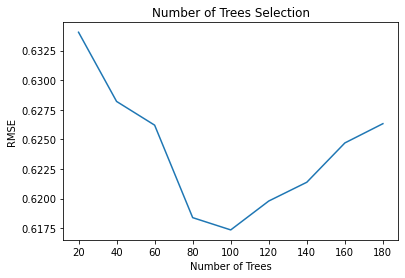

Best number of trees: 100


In [92]:
rmse = []
array = np.arange(20,200,20)
for alpha in tqdm(array):
    RFReg = RandomForestRegressor(n_estimators = alpha, random_state = 0)
    RFReg.fit(X_train,y_train)
    rmse.append(mean_squared_error(y_test, RFReg.predict(X_test), squared=False))
    
plt.plot(array, rmse)
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Number of Trees Selection')
plt.show()

best_alpha = array[min(range(len(rmse)), key=rmse.__getitem__)]

print(f"Best number of trees: {best_alpha}")

In [93]:
RFReg = RandomForestRegressor(n_estimators = best_alpha, random_state = 0)
RFReg.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

In [94]:
rf_r_squared_train = RFReg.score(X_train, y_train)
rf_r_squared_test = RFReg.score(X_test, y_test)
rf_train_rmse = mean_squared_error(y_train, RFReg.predict(X_train), squared=False)
rf_test_rmse = mean_squared_error(y_test, RFReg.predict(X_test), squared=False)

Training set R-squared (using Random Forest Regressor): 0.9837364707371171
Training set RMSE (using Random Forest Regressor): 0.24917225263703466


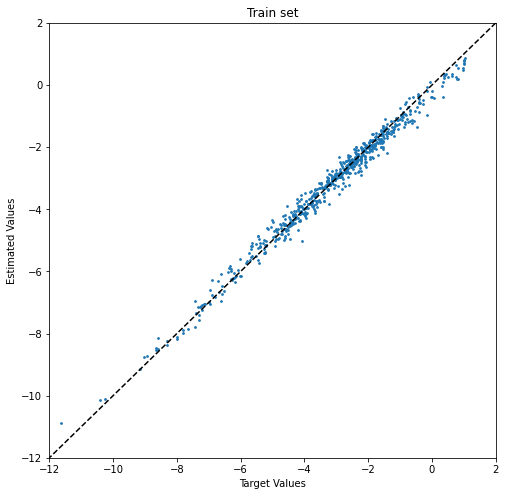

In [95]:
print(f"Training set R-squared (using Random Forest Regressor): {rf_r_squared_train}")
print(f"Training set RMSE (using Random Forest Regressor): {rf_train_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_train, RFReg.predict(X_train), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Train set");

Test set R-squared (using Random Forest Regressor): 0.9182486267466977
Test set RMSE (using Random Forest Regressor): 0.6173611751747189


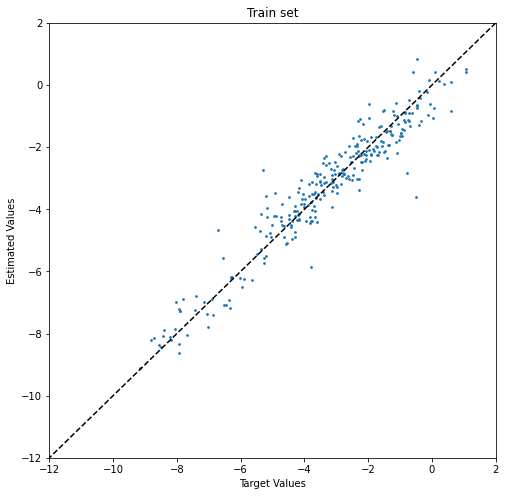

In [96]:
print(f"Test set R-squared (using Random Forest Regressor): {rf_r_squared_test}")
print(f"Test set RMSE (using Random Forest Regressor): {rf_test_rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_test, RFReg.predict(X_test), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Train set");

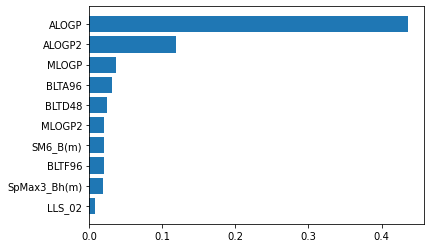

In [101]:
f_i = list(zip(col_labels,RFReg.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i][-10:],[x[1] for x in f_i][-10:])

plt.show()

## Gradient Boosting Regression

In [117]:
from sklearn.ensemble import GradientBoostingRegressor

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [114]:
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

rmse = mean_squared_error(y_test, reg.predict(X_test), squared=False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

The root mean squared error (RMSE) on test set: 0.5947


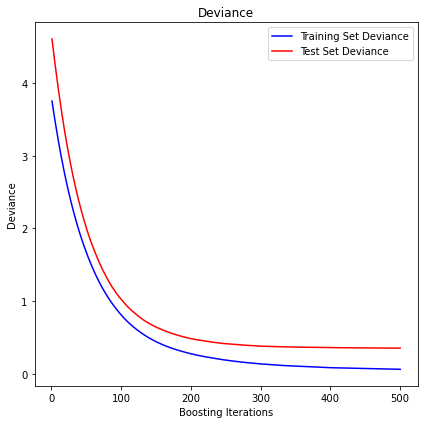

In [108]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Test set R-squared (using Gradient Boost Regressor): 0.9241375244358413
Test set RMSE (using Gradient Boost Regressor): 0.5947100681124443


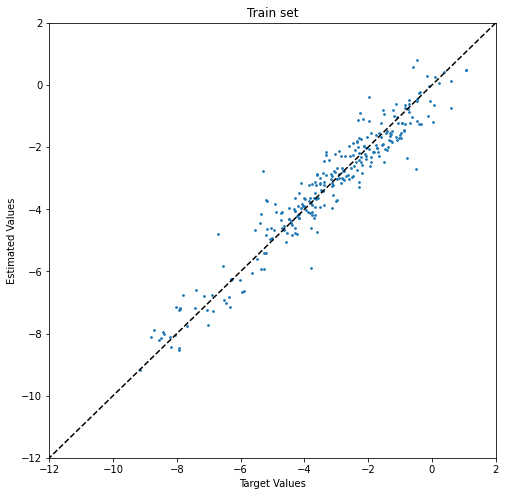

In [116]:
gb_r_squared_test = reg.score(X_test, y_test)
print(f"Test set R-squared (using Gradient Boost Regressor): {gb_r_squared_test}")
print(f"Test set RMSE (using Gradient Boost Regressor): {rmse}")
plt.figure(figsize=(8,8))
plt.scatter(y_test, reg.predict(X_test), s=3)
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')
plt.xlim([-12, 2])
plt.ylim([-12, 2])
plt.xlabel('Target Values')
plt.ylabel('Estimated Values')
plt.title("Train set");

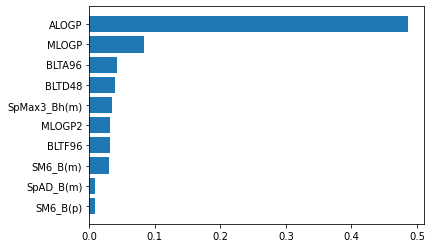

In [115]:
f_i = list(zip(col_labels,reg.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i][-10:],[x[1] for x in f_i][-10:])

plt.show()

## Outlier Analysis

In [27]:
def find_outliers(y_true, y_predicted, threshold):
    
    residuals = []
    for i in range(len(y_true)):
        residual = y_true[i] - y_predicted[i]
        residuals.append(residual)
    
    outliers = []
    for resid in residuals:
        if abs(resid) > threshold:
            outliers.append('outlier')
        else:
            outliers.append('not-outlier')
    return outliers


In [28]:
df = raw_df[['Compound_Identifier', 'SMILES', 'LogS.M.']].copy()
df['predictions'] = pls.predict(X)
df['residuals'] = df['LogS.M.'] - df.predictions
df['outlier?'] = find_outliers(df['LogS.M.'].to_list(), df.predictions.to_list(), 1)
df.head()

,Compound_Identifier,SMILES,LogS.M.,predictions,residuals,outlier?
0,HU_100,c1ccc2ccc3nccnc3c2c1,-2.68,-3.310583,0.630583,not-outlier
1,HU_1000,c1cnc2c(C)ncnc2n1,-0.12,-1.200588,1.080588,outlier
2,HU_1001,c1cnc2cnc(C)nc2n1,-0.47,-1.223914,0.753914,not-outlier
3,HU_1002,c1c(C)nc2cncnc2n1,0.06,-1.064983,1.124983,outlier
4,HU_1003,c1cnc2c(OC)ncnc2n1,-1.11,-0.759106,-0.350894,not-outlier


In [29]:
df['outlier?'].value_counts()

not-outlier    826
outlier        106
Name: outlier?, dtype: int64

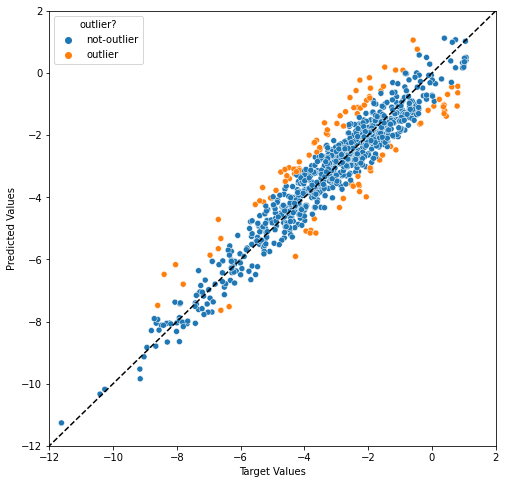

In [30]:
import seaborn as sns

plt.figure(figsize=(8,8))

ax = sns.scatterplot(data=df, x='LogS.M.', y='predictions', hue='outlier?')
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')

ax.set(ylim=(-12, 2),
       xlim=(-12, 2),
       ylabel='Predicted Values',
       xlabel='Target Values')

plt.show()

In [31]:
outlier_df = df[df['outlier?'] == 'outlier']
outlier_df.reset_index(inplace=True)
outlier_df.head()

,index,Compound_Identifier,SMILES,LogS.M.,predictions,residuals,outlier?
0,1,HU_1000,c1cnc2c(C)ncnc2n1,-0.12,-1.200588,1.080588,outlier
1,3,HU_1002,c1c(C)nc2cncnc2n1,0.06,-1.064983,1.124983,outlier
2,14,HU_1012,c1ccccc1NC(=O)NN,-2.33,-1.103548,-1.226452,outlier
3,30,HU_1028,O=C(OC)c(c(O)ccc1)c1,-2.34,-1.308133,-1.031867,outlier
4,31,HU_1029,O=C(O)c(ccc(O)c1OC)c1,-2.05,-0.876990,-1.173010,outlier


In [32]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

outlier_df['mols'] = outlier_df.SMILES.apply(lambda x: Chem.MolFromSmiles(x))
outlier_df.dropna(subset='mols', inplace=True)
outlier_df['fingerprint'] = outlier_df.mols.apply(lambda x: rdkit_gen.GetFingerprint(x))
fingerprints = outlier_df['fingerprint'].to_list()

[13:49:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9
[13:49:55] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 9


In [33]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

 With a cutoff of: 0.0, total # clusters:  99
 With a cutoff of: 0.1, total # clusters:  93
 With a cutoff of: 0.2, total # clusters:  90
 With a cutoff of: 0.3, total # clusters:  82
 With a cutoff of: 0.4, total # clusters:  77
 With a cutoff of: 0.5, total # clusters:  69
 With a cutoff of: 0.6, total # clusters:  51
 With a cutoff of: 0.7, total # clusters:  38
 With a cutoff of: 0.8, total # clusters:  17
 With a cutoff of: 0.9, total # clusters:  7


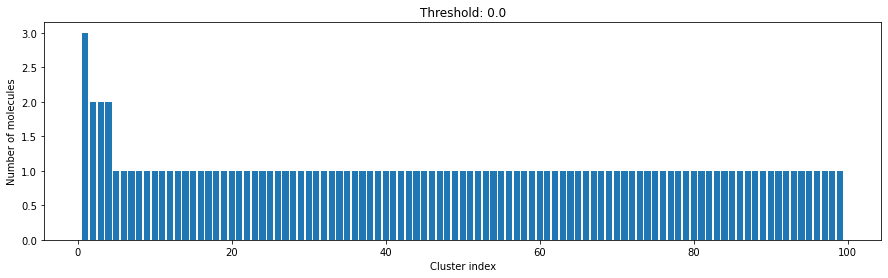

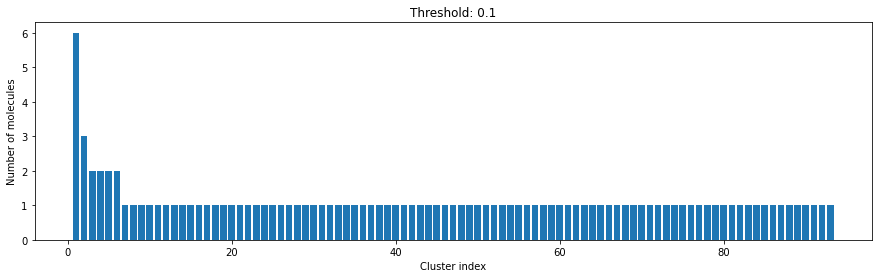

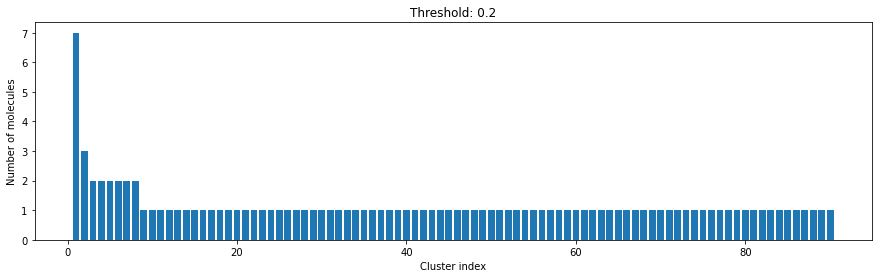

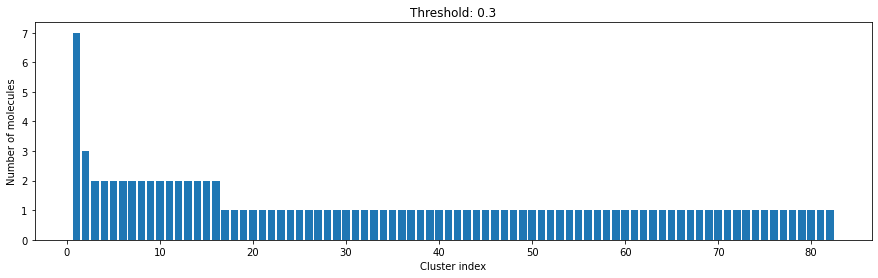

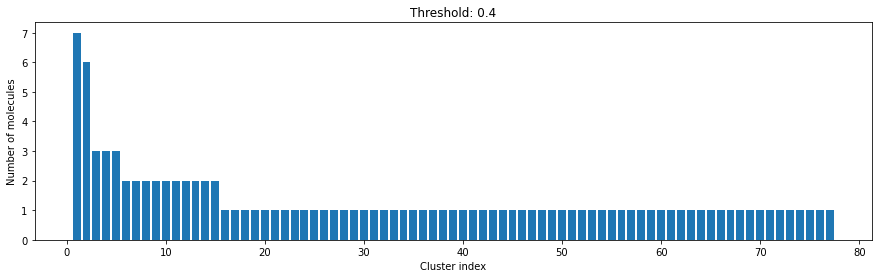

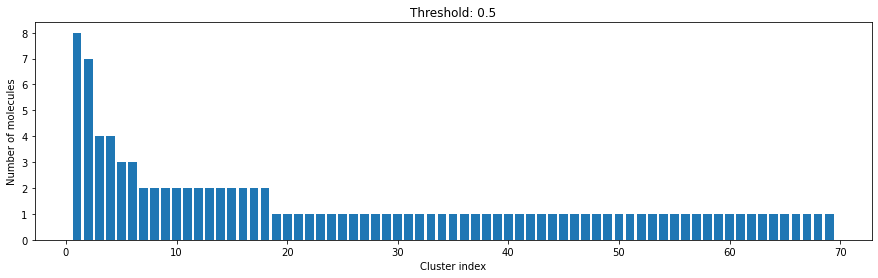

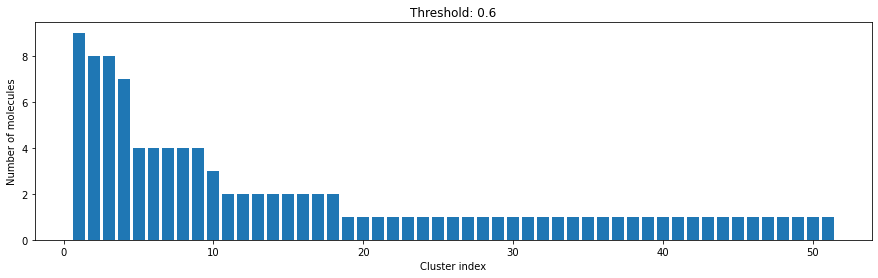

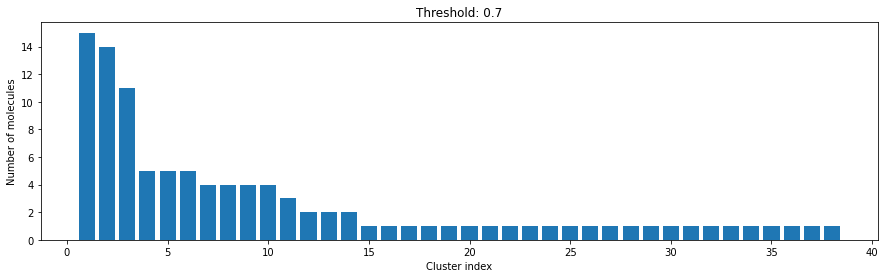

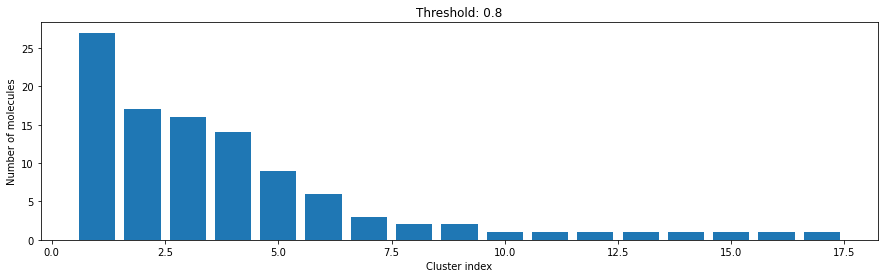

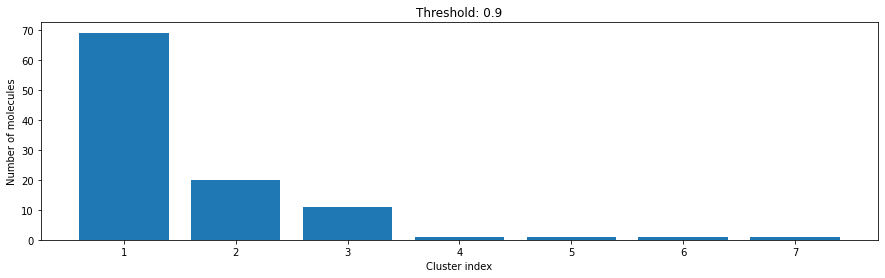

In [34]:
for cutoff in np.arange(0,1,0.1):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    print(f" With a cutoff of: {cutoff:.1f}, total # clusters: ", len(clusters))
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

In [35]:
#Visual examination of largest cluster with threshold 0.9
largest_cluster = []
for i in clusters[0]:
    largest_cluster.append(outlier_df['mols'].to_list()[i])
    
mols2grid.display(largest_cluster)

MolGridWidget()

In [36]:
outlier_df["cluster"] = np.nan

for i in range(len(clusters)):
    for mol_index in clusters[i]:
        outlier_df.at[mol_index, 'cluster'] = str(i+1)

In [37]:
df = pd.merge(df, outlier_df[['Compound_Identifier', 'cluster']], how='left')

In [38]:
df.cluster = df.cluster.fillna('not_outlier')

In [39]:
df.sort_values(by='cluster', inplace=True)

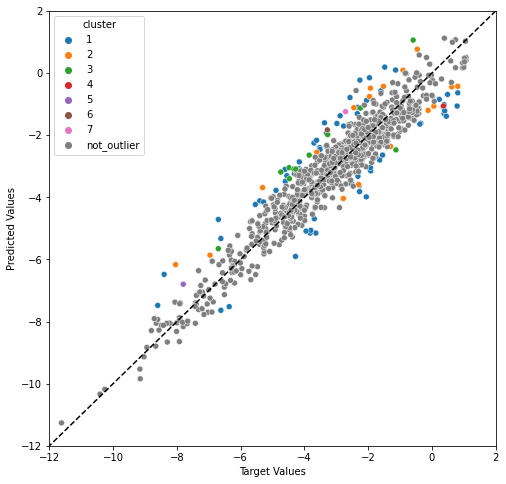

In [40]:
import seaborn as sns

plt.figure(figsize=(8,8))

ax = sns.scatterplot(data=df, x='LogS.M.', y='predictions', hue='cluster')
x = np.linspace(2, -12, 1000)
plt.plot(x, x, '--k')

ax.set(ylim=(-12, 2),
       xlim=(-12, 2),
       ylabel='Predicted Values',
       xlabel='Target Values')

plt.show()